In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#Khởi tạo Spark session
spark = SparkSession.builder.appName("EarthquakeRegression").getOrCreate()

In [0]:
df = spark.read.parquet("abfss://gold@bigdatacuoiky.dfs.core.windows.net/earthquake_events_gold/")
df.show(5)
df.printSchema()
df.describe().show()
df.columns


+------------+------------+-----------+-----------+--------------------+--------------------+---+----+-------+--------------------+--------------------+---------+
|          id|   longitude|   latitude|  elevation|               title|   place_description|sig| mag|magType|                time|             updated|sig_class|
+------------+------------+-----------+-----------+--------------------+--------------------+---+----+-------+--------------------+--------------------+---------+
|ak0219pcfvx9|   -155.2341|     65.771|        4.0|M 0.9 - 54 km E o...|54 km E of Huslia...| 12| 0.9|     ml|2021-07-30 23:59:...|2021-08-13 03:19:...|      Low|
|  ok2021ovmz|-97.50583333|36.97083333|       3.28|M 1.9 - 9 km WSW ...|9 km WSW of Hunne...| 53|1.85|     ml|2021-07-30 23:54:...|2021-08-02 14:25:...|      Low|
|  nc73602856|-119.5573333|    38.4215|       5.14|M 1.6 - 26km ENE ...|26km ENE of Darda...| 39|1.59|     md|2021-07-30 23:54:...|2021-08-07 06:38:...|      Low|
|  tx2021ovmy|-98.6308

['id',
 'longitude',
 'latitude',
 'elevation',
 'title',
 'place_description',
 'sig',
 'mag',
 'magType',
 'time',
 'updated',
 'sig_class']

In [0]:
# Chọn các cột đặc trưng và mục tiêu
features_cols = ['longitude', 'latitude', 'elevation', 'sig']
target_col = 'mag'

In [0]:
# Kiểm tra missing columns
missing_cols = [col for col in features_cols + [target_col] if col not in df.columns]
if missing_cols:
    print(f"Missing columns: {missing_cols}")
    print(f"Available columns: {df.columns}")
    spark.stop()
    exit()

In [0]:
# Kiểm tra giá trị null
for c in features_cols + [target_col]:
    null_count = df.filter(col(c).isNull() | isnan(col(c))).count()
    print(f"{c} nulls: {null_count}")
    if null_count > 0:
        df = df.dropna(subset=[c])

longitude nulls: 0
latitude nulls: 0
elevation nulls: 0
sig nulls: 0
mag nulls: 82


In [0]:
# Loại bỏ outlier theo IQR
quantiles = df.approxQuantile(target_col, [0.25, 0.75], 0.01)
Q1, Q3 = quantiles
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df.filter((col(target_col) >= lower_bound) & (col(target_col) <= upper_bound))

print(f"Số dòng sau khi loại outlier: {df_clean.count()}")

Số dòng sau khi loại outlier: 733909


In [0]:
# Vector hóa đặc trưng
assembler = VectorAssembler(inputCols=features_cols, outputCol="features_vec")
df_vec = assembler.transform(df_clean)

In [0]:
# Chuẩn hóa đặc trưng
scaler = StandardScaler(inputCol="features_vec", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

In [0]:
df_limited = df_scaled.limit(30000)

# Chia train/test
train_df, test_df = df_limited.randomSplit([0.8, 0.2], seed=42)

In [0]:
# Xây dựng mô hình Random Forest với hyperparameter tuning
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, seed=42)
paramGrid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [100, 200])
    .addGrid(rf.maxDepth, [10, 20, 30])
    .addGrid(rf.minInstancesPerNode, [1, 2])
    .build()
)

In [0]:
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, parallelism=2)
cv_model = cv.fit(train_df)

In [0]:
# Đánh giá mô hình
best_model = cv_model.bestModel
print("Best Params:")
print(f"  numTrees: {best_model.getNumTrees}")
print(f"  maxDepth: {best_model.getOrDefault('maxDepth')}")
print(f"  minInstancesPerNode: {best_model.getOrDefault('minInstancesPerNode')}")


Best Params:
  numTrees: 200
  maxDepth: 20
  minInstancesPerNode: 2


In [0]:
train_pred = best_model.transform(train_df)
test_pred = best_model.transform(test_df)

In [0]:
train_rmse = evaluator.evaluate(train_pred)
test_rmse = evaluator.evaluate(test_pred)
mae_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mae")
train_mae = mae_evaluator.evaluate(train_pred)
test_mae = mae_evaluator.evaluate(test_pred)
r2_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")
train_r2 = r2_evaluator.evaluate(train_pred)
test_r2 = r2_evaluator.evaluate(test_pred)

In [0]:
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")

Train RMSE: 0.0715, Test RMSE: 0.0867
Train MAE: 0.0308, Test MAE: 0.0399
Train R2: 0.9924, Test R2: 0.9889


In [0]:
# Feature importance
importances = best_model.featureImportances
for idx, col_name in enumerate(features_cols):
    print(f"{col_name}: {importances[idx]:.4f}")

longitude: 0.0284
latitude: 0.0707
elevation: 0.0348
sig: 0.8661


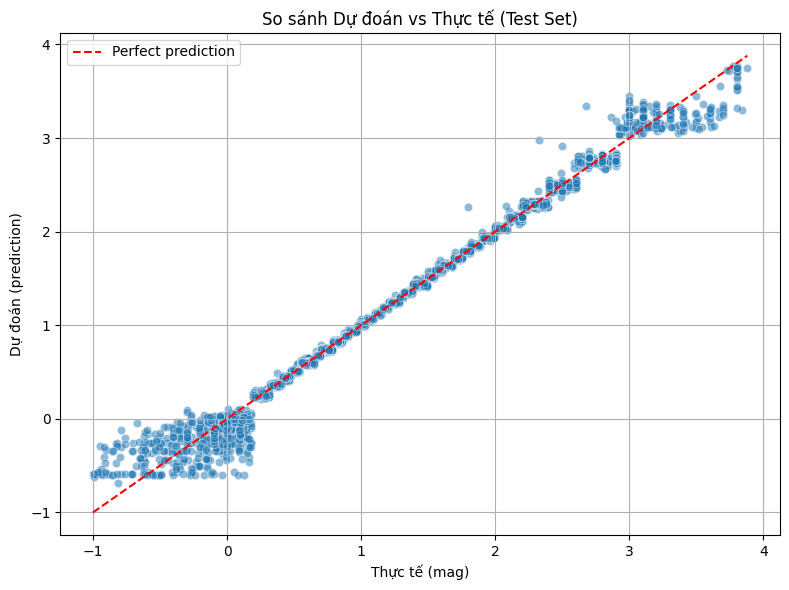

In [0]:
test_results_pd = test_pred.select("mag", "prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="mag", y="prediction", data=test_results_pd, alpha=0.5)
plt.plot([test_results_pd["mag"].min(), test_results_pd["mag"].max()],
         [test_results_pd["mag"].min(), test_results_pd["mag"].max()],
         color='red', linestyle='--', label='Perfect prediction')
plt.xlabel("Thực tế (mag)")
plt.ylabel("Dự đoán (prediction)")
plt.title("So sánh Dự đoán vs Thực tế (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
# So sánh thực tế vs dự đoán (10 mẫu đầu)
test_pred.select(target_col, "prediction").show(10)

+---+------------------+
|mag|        prediction|
+---+------------------+
|1.8|  1.80307311076846|
|1.9|1.9025489809446279|
|1.2|1.2000541036660564|
|2.3| 2.295991594489936|
|1.8|1.8018115342546261|
|1.5|1.4971472463800564|
|1.7|1.6981022889123565|
|1.3| 1.299333258859012|
|1.7|1.6988497863247805|
|2.4|2.5110135852055047|
+---+------------------+
only showing top 10 rows

